# **APPENDIX A: DATA CLEANING**

In [1]:
#import libraries
import math
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

In [2]:
#mount drive for data files 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import dataset and remove empty rows and columns
temp = pd.read_excel('/content/drive/MyDrive/AAI500/Project/Dataset.xlsx')
temp = temp.dropna(how='all', axis=0)
temp = temp.dropna(how ='all', axis=1)

In [4]:
#Make weather column numerical 
#Sunset=7, Sunrise=6, Sunny=5, slightly cloudy=4, rainy=3, =2, dark=1, cloudy=0
temp['Weather'] = temp['Weather'].astype('category')
temp['Weather'] = temp['Weather'].cat.codes

In [5]:
#rename column, check if battery was charged, find rate of SOC, find heating rate
temp.rename(columns={'Unnamed: 8':'delta_SOC'}, inplace=True)
temp.drop(temp[temp['delta_SOC'] < 0].index, inplace=True)
temp['SOC_rate'] = (temp['delta_SOC']) / temp['Duration [min]']
temp['heat_rate'] = (temp['Battery Temperature (End)']-temp['Battery Temperature (Start) [°C]']) / temp['Duration [min]']

# **APPENDIX B: EXPLORATORY DATA ANALYSIS**

In [6]:
#scatter plot for relevant features
def feature_plots(df, columns, num_cols):
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(18,18))
    plt.rcParams.update({'font.size': 15})
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        x = df[columns[i]]
        y = df['heat_rate']
        m, b = np.polyfit(x,y,1)
        plt.scatter(x,y)
        plt.plot(x, m*x+b, color = 'red')
        ax.set_xlabel(columns[i])
        ax.set_ylabel('Battery Heating Rate [°C/min]')
        ax.set_title('{} vs. {};'.format(columns[i], 'Battery Heating Rate [°C/min]'))
    fig.tight_layout()
    plt.show()

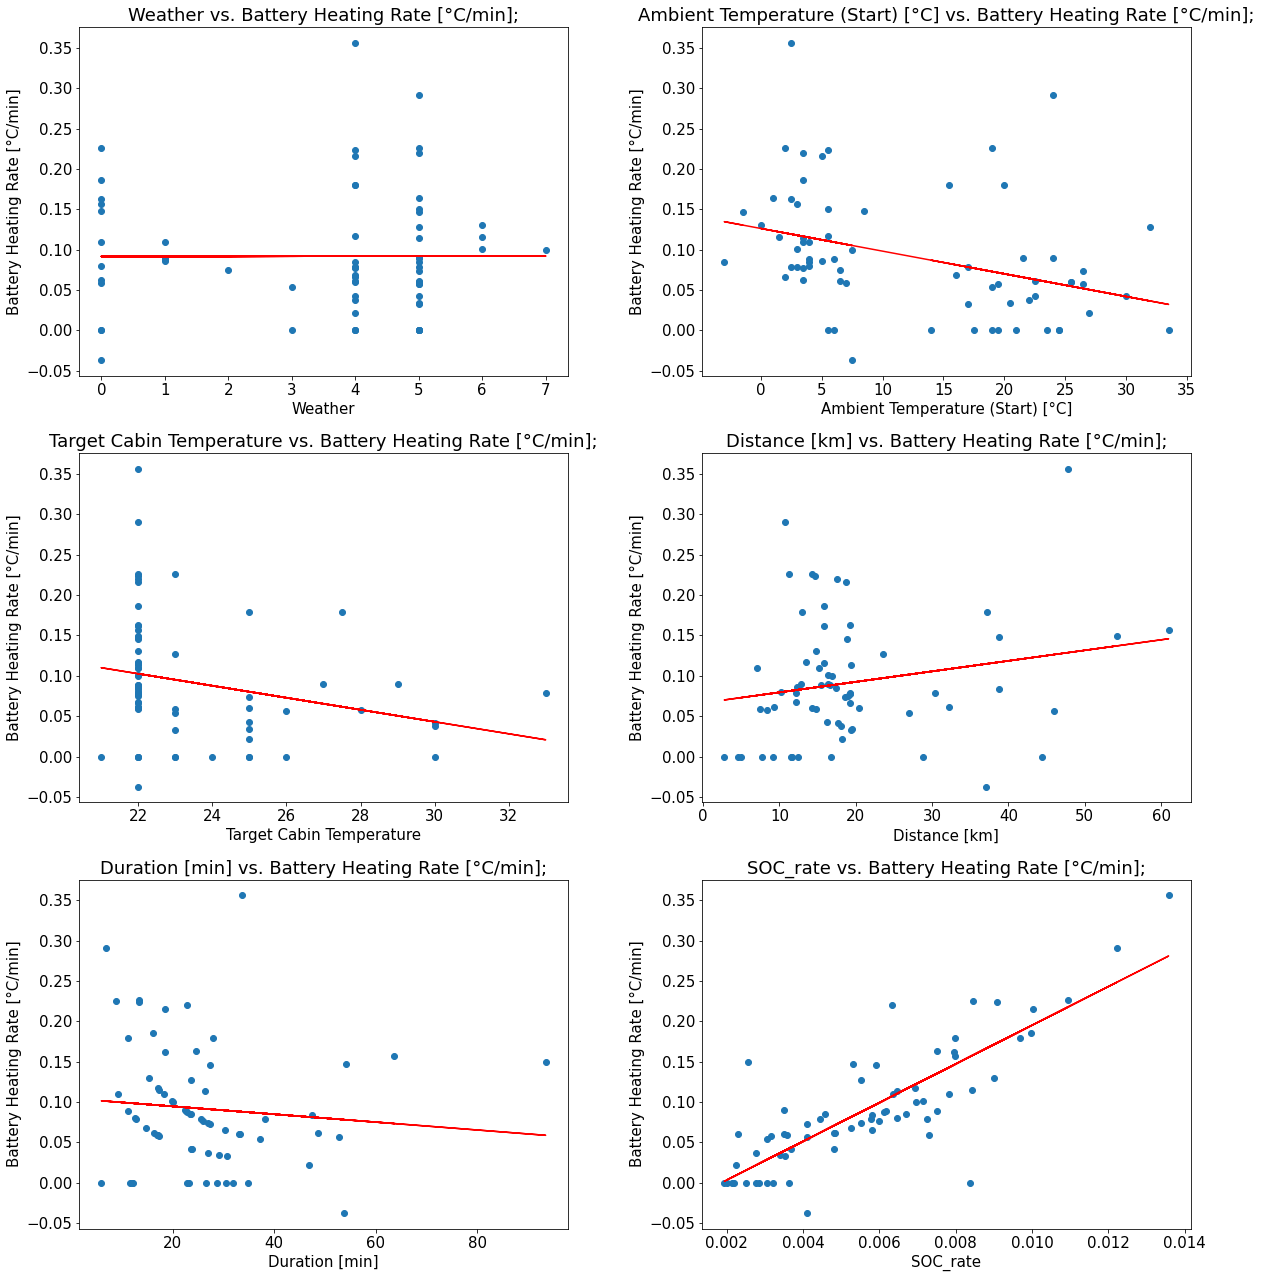

In [7]:
feature_plots(temp, ['Weather','Ambient Temperature (Start) [°C]', 
                     'Target Cabin Temperature', 'Distance [km]', 
                     'Duration [min]', 'SOC_rate'], 2)

In [8]:
#Create new dataframe with the features from scatter plot
temp = temp[['heat_rate', 'Weather', 'Ambient Temperature (Start) [°C]', 
             'Target Cabin Temperature', 'Distance [km]', 'Duration [min]', 
             'SOC_rate']].copy()

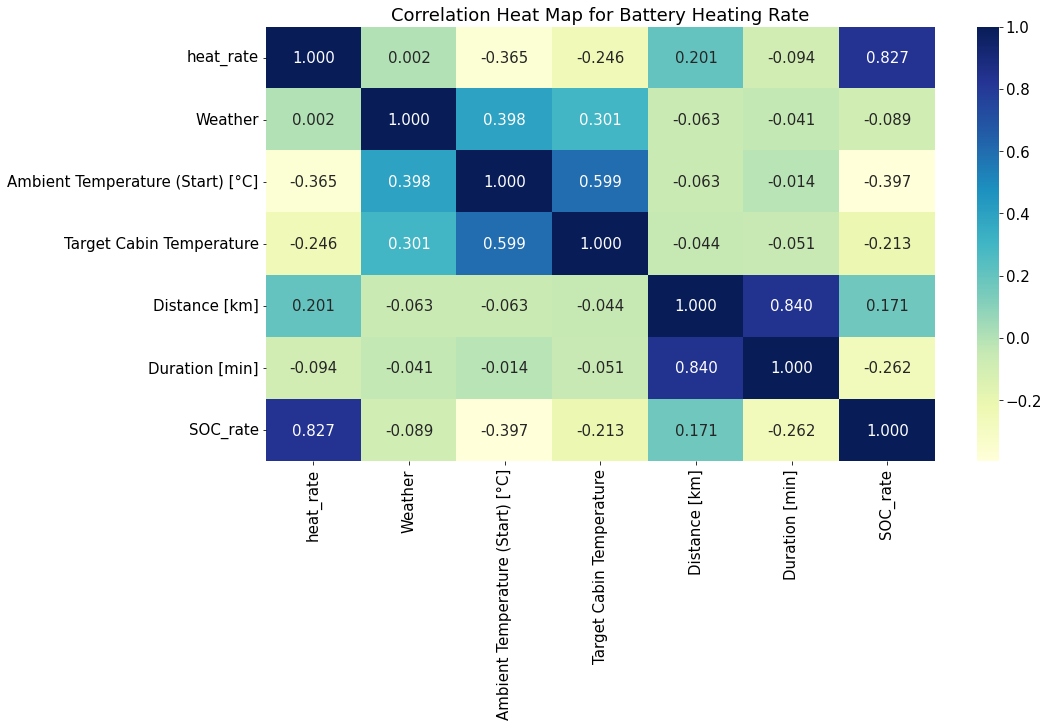

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(temp.corr(),annot=True, fmt='0.3f', cmap='YlGnBu')
plt.title('Correlation Heat Map for Battery Heating Rate')
plt.show()

In [10]:
print(temp.describe().T)

                                  count       mean        std        min  \
heat_rate                          68.0   0.091763   0.076233  -0.037204   
Weather                            68.0   3.558824   1.995385   0.000000   
Ambient Temperature (Start) [°C]   68.0  12.250000   9.915878  -3.000000   
Target Cabin Temperature           68.0  23.448529   2.523235  21.000000   
Distance [km]                      68.0  19.444819  11.775561   2.782300   
Duration [min]                     68.0  25.816225  14.725627   5.906667   
SOC_rate                           68.0   0.005689   0.002632   0.001932   

                                        25%        50%        75%        max  
heat_rate                          0.042277   0.078644   0.128122   0.355872  
Weather                            2.750000   4.000000   5.000000   7.000000  
Ambient Temperature (Start) [°C]   3.500000   7.250000  21.125000  33.500000  
Target Cabin Temperature          22.000000  22.000000  25.000000  33.00000

# **APPENDIX C: MODEL SELECTION AND ANALYSIS**

In [11]:
#Independent variables, dependent variable, respectively
x = temp.loc[:, temp.columns != 'heat_rate']
y = pd.DataFrame(temp['heat_rate'])

In [12]:
#Function used to split train/test data and fit the model 
def model_creation(seed):
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=seed)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())

In [13]:
print(model_creation(10))

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     21.18
Date:                Thu, 23 Feb 2023   Prob (F-statistic):           5.27e-11
Time:                        00:24:47   Log-Likelihood:                 94.298
No. Observations:                  47   AIC:                            -174.6
Df Residuals:                      40   BIC:                            -161.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [14]:
print(model_creation(38))

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     34.02
Date:                Thu, 23 Feb 2023   Prob (F-statistic):           3.21e-14
Time:                        00:24:47   Log-Likelihood:                 94.952
No. Observations:                  47   AIC:                            -175.9
Df Residuals:                      40   BIC:                            -163.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [15]:
print(model_creation(99))

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     27.63
Date:                Thu, 23 Feb 2023   Prob (F-statistic):           9.12e-13
Time:                        00:24:47   Log-Likelihood:                 93.355
No. Observations:                  47   AIC:                            -172.7
Df Residuals:                      40   BIC:                            -159.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

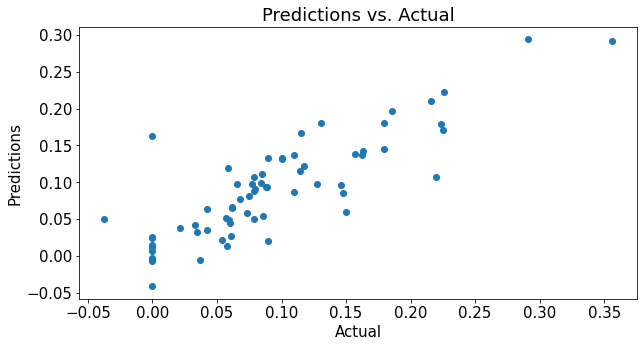

In [16]:
#Final model
x1 = temp['Weather']
x2 = temp['Ambient Temperature (Start) [°C]']
x3 = temp['Target Cabin Temperature']
x4 = temp['Distance [km]']
x5 = temp['Duration [min]']
x6 = temp['SOC_rate']
y_calc = -0.053+0.003*x1+0.001*x2-0.003*x3-0.002*x4+0.002*x5+31.201*x6

fig = plt.figure(figsize=(10,5))
plt.scatter(temp['heat_rate'], y_calc)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

In [17]:
for i in range(0,69):
  diff = abs(y_calc-temp['heat_rate'])

print(diff.max())
print(diff.min())

0.1627526195722658
0.0006944407417486254
